# Modeling and Simulation in Python

Chapter 2: Simulation

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the functions defined in the `modsim` module.

In [ ]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

%matplotlib notebook

from modsim import *

## More than one System object

Here's the code from the previous chapter, with two changes:

1. I've added DocStrings that explain what each function does, and what parameters it takes.

2. I've added a parameter named `system` to the functions so they work with whatever `System` object we give them, instead of always using `bikeshare`.  That will be useful soon when we have more than one `System` object.

In [ ]:
def run_steps(system, num_steps=1, p1=0.5, p2=0.5):
    """Simulate the given number of time steps.
    
    system: bikeshare System object
    num_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    for i in range(num_steps):
        step(system, p1, p2)
        plot_system(system)
        
def step(system, p1=0.5, p2=0.5):
    """Simulate one minute of time.
    
    system: bikeshare System object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(system)
    
    if flip(p2):
        bike_to_olin(system)
        
def bike_to_wellesley(system):
    """Move one bike from Olin to Wellesley.
    
    system: bikeshare System object
    """
    move_bike(system, 1)
    
def bike_to_olin(system):
    """Move one bike from Wellesley to Olin.
    
    system: bikeshare System object
    """
    move_bike(system, -1)
    
def move_bike(system, n):
    """Move a bike.
    
    system: bikeshare System object
    n: +1 to move from Olin to Wellesley or
       -1 to move from Wellesley to Olin
    """
    system.olin -= n
    system.wellesley += n
    
def plot_system(system):
    """Plot the current system of the bikeshare system.
    
    system: bikeshare System object
    """
    plot(system.olin, 'rs-', label='Olin')
    plot(system.wellesley, 'bo-', label='Wellesley')
    
def decorate_bikeshare():
    """Add a title and label the axes."""
    decorate(title='Olin-Wellesley Bikeshare',
               xlabel='Time step (min)', 
               ylabel='Number of bikes')

Now we can create more than one `System` object:

In [ ]:
bikeshare1 = System(olin=10, wellesley=2)
bikeshare1

In [ ]:
bikeshare2 = System(olin=10, wellesley=2)
bikeshare2

And whenever we call a function, we indicate which `System` object to work with:

In [ ]:
bike_to_olin(bikeshare1)

In [ ]:
bike_to_wellesley(bikeshare2)

And you can confirm that the different systems are getting updated independently:

In [ ]:
bikeshare1

In [ ]:
bikeshare2

## Negative bikes

In the code we have so far, the number of bikes at one of the locations can go negative, and the number of bikes at the other location can exceed the actual number of bikes in the system.

If you run this simulation a few times, it happens quite often.

In [ ]:
bikeshare = System(olin=10, wellesley=2)
newfig()
plot_system(bikeshare)
decorate_bikeshare()
run_steps(bikeshare, 60, 0.4, 0.2)

But this is relatively easy to fix, using the `return` statement to exit the function early if the update would cause negative bikes.

If the second `if` statement seems confusing, remember that `n` can be negative.

In [ ]:
def move_bike(system, n):
    # make sure the number of bikes won't go negative
    olin_temp = system.olin - n
    if olin_temp < 0:
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        return
    
    # update the system
    system.olin = olin_temp
    system.wellesley = wellesley_temp

Now if you run the simulation again, it should behave.

In [ ]:
bikeshare = System(olin=10, wellesley=2)
newfig()
plot_system(bikeshare)
decorate_bikeshare()
run_steps(bikeshare, 60, 0.4, 0.2)

The variables `olin` and `wellesley` are created inside `move_bike`, so they are local.  When the function ends, they go away.

If you try to access a local variable from outside its function, you get an error:

In [ ]:
# If you remove the # from the last line in this cell and run it, you'll get
# NameError: name 'olin' is not defined

olin

**Exercise:** Add print statements in `move_bike` so it prints a message each time a customer arrives and doesn't find a bike.  Run the simulation again to confirm that it works as you expect.  Then you might want to remove the print statements before you go on.

## Comparison operators

The `if` statements in the previous section used the comparison operator `<`.  The other comparison operators are listed in the book.

It is easy to confuse the comparison operator `==` with the assignment operator `=`.

Remember that `=` creates a variable or gives an existing variable a new value.

In [ ]:
x = 4

Whereas `==` compared two values and returns `True` if they are equal.

In [ ]:
x == 5

You can use `==` in an `if` statement.

In [ ]:
if x == 5:
    print('yes, x is 5')

But if you use `=` in an `if` statement, you get an error.

In [ ]:
# If you remove the # from the if statement and run it, you'll get
# SyntaxError: invalid syntax

if x == 5:
    print('yes, x is 5')
else:
    print('ha no')

**Exercise:** Add an `else` clause to the `if` statement above, and print an appropriate message.

Replace the `==` operator with one or two of the other comparison operators, and confirm they do what you expect.

## Metrics

Now that we have a working simulation, we'll use it to evaluate alternative designs and see how good or bad they are.  The metric we'll use is the number of customers who arrive and find no bikes available, which might indicate a design problem.

First we'll make a new `System` object that creates and initializes the system variables that will keep track of the metrics.

In [ ]:
bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0, clock = 0)

Next we need a version of `move_bike` that updates the metrics.

In [ ]:
def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        system.wellesley_empty += 1
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

Now when we run a simulation, it keeps track of unhappy customers.

In [ ]:
newfig()
plot_system(bikeshare)
decorate_bikeshare()
run_steps(bikeshare, 60, 0.4, 0.2)

After the simulation, we can print the number of unhappy customers at each location.

In [ ]:
bikeshare.olin_empty

In [ ]:
bikeshare.wellesley_empty

**Exercise:** Let's add a "clock" to keep track of how many time steps have elapsed:

1. Add a new system variable named `clock` to `bikeshare`, initialized to 0, and 

2. Modify `step` so it increments (adds one to) `clock` each time it is invoked.

Test your code by adding a print statement that prints the value of `clock` at the beginning of each time step.

In [ ]:
# Here's a copy of step to get you started

def step(system, p1=0.5, p2=0.5):
    """Simulate one minute of time.
    
    system: bikeshare System object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(system)
        system.clock +=1
    
    if flip(p2):
        bike_to_olin(system)
        system.clock+=1

In [ ]:
# Solution goes here


In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

After the simulation, check the final value of `clock`.

In [ ]:
print(bikeshare.clock)

**Exercise:** Now suppose we'd like to know how long it takes to run out of bikes at either location.  Modify `move_bike` so the first time a student arrives at Olin and doesn't find a bike, it records the value of `clock` in a system variable.

Hint: create a system variable named `t_first_empty` and initialize it to `-1` to indicate that it has not been set yet.

Test your code by running a simulation for 60 minutes and checking the metrics.

In [ ]:
# Solution goes here
bikeshare.t_first_empty = -1

def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        bikeshare.t_first_empty = system.clock
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        system.wellesley_empty += 1
        bikeshare.t_first_empty = system.clock
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

In [ ]:
# Solution goes here

newfig()
bikeshare.clock = 0
for i in range(60):
    step(bikeshare, .5, .5)
    plot_system(bikeshare)
    decorate_bikeshare()

In [ ]:
# Solution goes here

After the simulation, check the final value of `t_first_empty`.

In [ ]:
print(bikeshare.t_first_empty)

Before we go on, let's put `step` and `move_bike` back the way we found them, so they don't break the examples below.

In [ ]:
def step(system, p1=0.5, p2=0.5):
    if flip(p1):
        bike_to_wellesley(system)
    
    if flip(p2):
        bike_to_olin(system)

def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        system.wellesley_empty += 1
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

## Returning values

Here's a simple function that returns a value:

In [ ]:
def add_five(x):
    return x + 5

And here's how we call it.

In [ ]:
y = add_five(3)
y

If you run a function on the last line of a cell, Jupyter displays the result:

In [ ]:
add_five(5)

But that can be a bad habit, because usually if you call a function and don't assign the result in a variable, the result gets discarded.

In the following example, Jupyter shows the second result, but the first result just disappears.

In [ ]:
add_five(3)
add_five(5)

When you call a function that returns a variable, it is generally a good idea to assign the result to a variable.

In [ ]:
y1 = add_five(3)
y2 = add_five(5)

print(y1, y2)

**Exercise:** Write a function called `make_system` that creates a `System` object with the system variables `olin=10` and `wellesley=2`, and then returns the new `System` object.

Write a line of code that calls `make_system` and assigns the result to a variable.

In [ ]:
# Solution goes here
def make_system(olin = 10, wellesley = 2):
    return System(olin = olin, wellesley = wellesley, olin_empty=0, wellesley_empty=0, clock = 0)

In [ ]:
# Solution goes here

bikeshare = make_system()
print(bikeshare)

## Running simulations

Before we go on, I want to update `run_steps` so it doesn't always plot the results.  The new version takes an additional parameter, `plot_flag`, to indicate whether we want to plot.

"flag" is a conventional name for a boolean variable that indicates whether or not a condition is true.

This version of `run_steps` works even if `num_steps` is not an integer.  It uses the `int` function to round down.  See https://docs.python.org/3/library/functions.html#int

In [ ]:
def run_steps(system, num_steps=1, p1=0.5, p2=0.5, plot_flag=True):
    """Simulate the given number of time steps.
    
    `num_steps` should be an integer; if not, it gets rounded down.
    
    system: bikeshare System object
    num_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    plot_flag: boolean, whether to plot
    """
    for i in range(int(num_steps)):
        step(system, p1, p2)
        if plot_flag:
            plot_system(system)

Now when we run a simulation, we can choose not to plot the results:

In [ ]:
bikeshare = System(olin=10, wellesley=2, 
                   olin_empty=0, wellesley_empty=0)
run_steps(bikeshare, 60, 0.4, 0.2, plot_flag=False)

But after the simulation, we can still read the metrics.

In [ ]:
bikeshare.olin_empty

Let's wrap all that in a function.

In [ ]:
def run_simulation():
    system = System(olin=10, wellesley=2, 
                    olin_empty=0, wellesley_empty=0)
    run_steps(system, 60, 0.4, 0.2, plot_flag=True)
    return system

And test it.

In [ ]:
system = run_simulation()


In [ ]:
print(system.olin_empty, system.wellesley_empty)

If we generalize `run_simulation` to take `p1` and `p2`, we can use it to run simulations with a range of values for the parameters.

In [ ]:
def run_simulation(p1=0.4, p2=0.2):
    system = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return system

When `p1` is small, we probably don't run out of bikes at Olin.

In [ ]:
system = run_simulation(p1=0.2)
system.olin_empty

When `p1` is large, we probably do.

In [ ]:
system = run_simulation(p1=0.6)
system.olin_empty

**Exercise:**  Write a version of `run_simulation` that takes all five model parameters as function parameters.

In [ ]:
# Solution goes here
def run_simulation(num_steps = 60, p1 = .5, p2 = .5, olin = 10, wellesley = 2):
    system = System(olin=olin, wellesley=wellesley, 
                    olin_empty=0, wellesley_empty=0)
    run_steps(system, num_steps, p1, p2, plot_flag=True)
    return system

In [ ]:
# Solution goes here
system = run_simulation()

## More for loops

`linspace` creates a NumPy array of equally spaced numbers.

In [ ]:
p1_array = linspace(start=0, stop=1, num=5)
p1_array

We can use an array in a `for` loop, like this:

In [ ]:
for p1 in p1_array:
    print(p1)

This will come in handy in the next section.

**Exercise:** The function `linspace` is part of NumPy.  [You can read the documentation here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html).

Use `linspace` to make an array of 10 equally spaced numbers from 1 to 10 (including both).

In [ ]:
# Solution goes here
array = linspace(start = 1, stop = 10, num = 10)
print(array)

**Exercise:** The `modsim` library provides a related function called `linrange`.  You can view the documentation by running the following cell:

In [ ]:
help(linrange)

Use `linrange` to make an array of numbers from 1 to 11 with a step size of 2.

In [ ]:
# Solution goes here
array = linrange(start = 1, stop = 11, step = 2)
print(array)

## Sweeping parameters

The following example runs simulations with a range of values for `p1`; after each simulation, it prints the number of unhappy customers at the Olin station:

In [228]:
p1_array = linspace(0, 1, 11)
p1_array

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [230]:
for p1 in p1_array:
    system = run_simulation(p1=p1)
    print(p1, system.olin_empty)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


0.1 0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


0.3 0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

0.6 0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

0.9 17


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
Now we can do the same thing, but plotting the results instead of printing them.



<IPython.core.display.Javascript object>


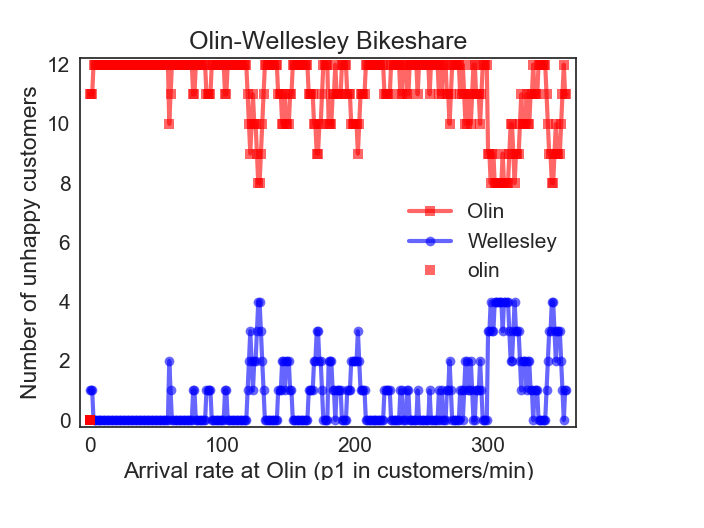

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

KeyboardInterrupt: 

In [231]:
newfig()
for p1 in p1_array:
    system = run_simulation(p1=p1)
    plot(p1, system.olin_empty, 'rs', label='olin')

As always, we should decorate the figure.  This version of `decorate_bikeshare` takes `xlabel` as a parameter, for reasons you will see soon.

In [232]:
def decorate_bikeshare(xlabel):
    decorate(title='Olin-Wellesley Bikeshare',
             xlabel=xlabel, 
             ylabel='Number of unhappy customers')

In [233]:
decorate_bikeshare(xlabel='Arrival rate at Olin (p1 in customers/min)')

**Exercise:** Wrap this code in a function named `parameter_sweep` that takes an array called `p1_array` as a parameter.  It should create a new figure, run a simulation for each value of `p1` in `p1_array`, and plot the results.

Once you have the function working, modify it so it also plots the number of unhappy customers at Wellesley.  Looking at the plot, can you estimate a range of values for `p1` that minimizes the total number of unhappy customers?

In [234]:
# Solution goes here
def parameter_sweep(p1_array):
    newfig()
    for p1 in p1_array:
        system = run_simulation(p1=p1)
        plot(p1, system.olin_empty, 'rs', label='olin')

<IPython.core.display.Javascript object>


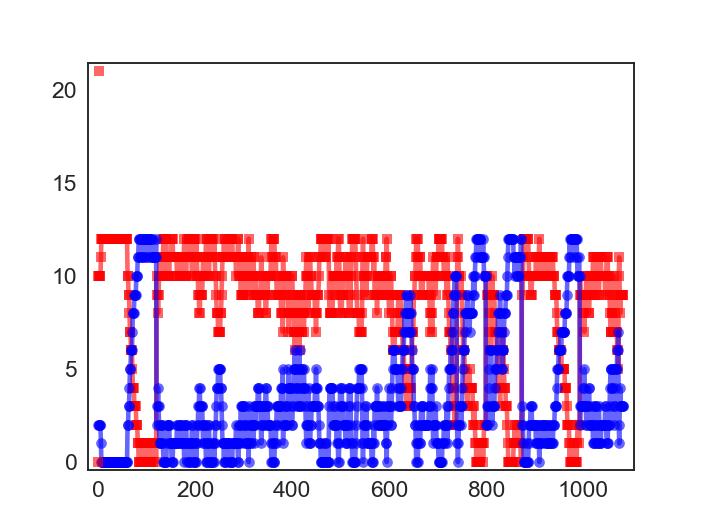

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [235]:
# Solution goes here
p1_array = linspace(0,1,2)
parameter_sweep(p1_array)


**Exercise:** Write a function called `parameter_sweep2` that runs simulations with `p1=0.2` and a range of values for `p2`.

Note: If you run `parameter_sweep2` a few times without calling `newfig`, you can plot multiple runs on the same axes, which will give you a sense of how much random variation there is from one run to the next. 

In [237]:
# Solution goes here
def parameter_sweep2(p1 = .2, p1_min = 0, p1_max = 1):
    newfig()
    p1_array = linrange(p1_min,p1_max,p1)
    for p1 in p1_array:
        system = run_simulation(p1=p1)
        plot(p1, system.olin_empty, 'rs', label='olin')

<IPython.core.display.Javascript object>


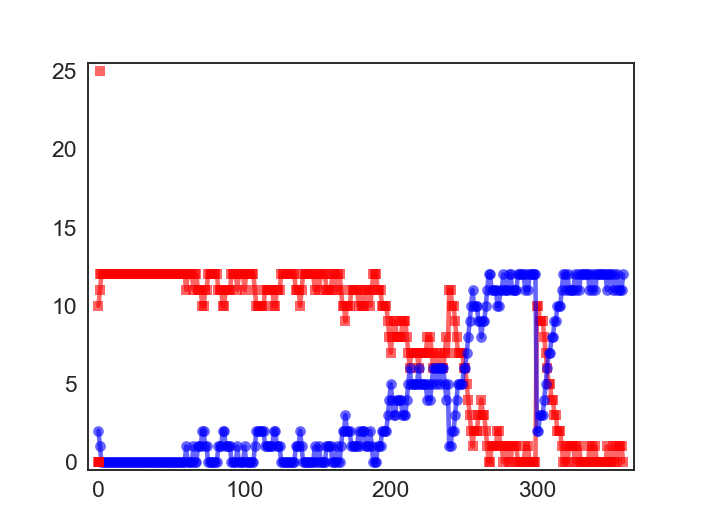

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

In [238]:
# Solution goes here
parameter_sweep2()

In [89]:
# Solution goes here

**Exercise:** Hold `p1=0.4` and `p2=0.2`, and sweep a range of values for `num_steps`.

Hint: You will need a version of `run_simulation` that takes `num_steps` as a parameter.

Hint: Because `num_steps` is supposed to be an integer use `range` rather than `linrange`.

In [246]:
# Solution goes here
steps = range(10,30,10)
for s in steps:
    run_simulation(s, p1 = .4, p2 = .2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [247]:
# Solution goes here
#no idea if this works, my computer is too slow to run it

In [248]:
# Solution goes here

**Exercise:** The code below runs a simulation with the same parameters 10 times and computes the average number of unhappy customers.

1.  Wrap this code in a function called `run_simulations` that takes `num_runs` as a parameter.

2.  Test `run_simulations`, and increase `num_runs` until the results are reasonably consistent from one run to the next.

3.  Generalize `run_simulations` so it also takes the initial value of `olin` as a parameter.

4.  Run the generalized version with `olin=12`.  How much do the two extra bikes decrease the average number of unhappy customers.

5.  Make a plot that shows the average number of unhappy customers as a function of the initial number of bikes at Olin.

In [260]:
num_runs = 2

total = 0
for i in range(num_runs):
    system = run_simulation(p1=0.4, p2=0.2, olin=10, wellesley=2, num_steps=2)
    total += system.olin_empty + system.wellesley_empty
total / num_runs

0.0

In [250]:
# Solution goes here
#can't run the code above, computer can't handle it, even with reduced numbers

In [261]:
# Solution goes here
def run_simulations(num_runs):
    total = 0
    for i in range(num_runs):
        system = run_simulation(p1=0.4, p2=0.2, olin=10, wellesley=2, num_steps=60)
        total += system.olin_empty + system.wellesley_empty
    total / num_runs

In [262]:
# Solution goes here
run_simulation(2)

,value
olin,9
wellesley,3
olin_empty,0
wellesley_empty,0


In [98]:
# Solution goes here

In [99]:
# Solution goes here